<a href="https://colab.research.google.com/github/devthumos/sentiment_analysis_nlp/blob/main/Projeto_PLN_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROJETO - Análise de Sentimentos de Corpus de Tweets utilizando tfidf e bag of words

In [1]:
!pip install nltk
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import re
from keras.models import Sequential
from keras.layers import Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import nltk
from google.colab import drive
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.regularizers import L1, L2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.initializers import RandomNormal

In [3]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

dataset from <a href="https://www.kaggle.com/datasets/kazanova/sentiment140">KAGGLE</a>

- target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- ids: The id of the tweet ( 2087)
- date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- flag: The query (lyx). If there is no query, then this value is NO_QUERY.
- user: the user that tweeted (robotickilldozr)
- text: the text of the tweet (Lyx is cool)

In [5]:
path_file = "/content/gdrive/MyDrive/training.1600000.processed.noemoticon.csv"
dataset = pd.read_csv(path_file, encoding="latin-1", names=["target", "ids", "date", "flags", "user", "text"])
dataset.head()

,target,ids,date,flags,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flags   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


O dataset está proporcional com relação a quantidade de targets positivos e negativos

In [7]:
dataset.target.unique()

array([0, 4])

In [8]:
dataset_negative = dataset[dataset.target == 0]
dataset_positive = dataset[dataset.target == 4]

In [9]:
print(dataset_negative.target.count())
print(dataset_positive.target.count())

800000
800000


Como o dataset é muito grande, pegaremos apenas 30 000 instâncias:
- Sendo 15 000 instâncias de target positivo
- Sendo 15 000 instâncias de target negativo

In [10]:
sample_negative = dataset_negative.iloc[0:15_000, :]
sample_positive = dataset_positive.iloc[0:15_000, :]
sample = pd.concat([sample_negative, sample_positive])
sample = sample.drop(["date", "user", "flags", "ids"], axis=1)
sample.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [11]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 814999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  30000 non-null  int64 
 1   text    30000 non-null  object
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


Normalizando e préprocessando o nosso sample

A lista de emoticons utilizados foi inspirada na lista de emoticons do <a href="https://en.wikipedia.org/wiki/List_of_emoticons">wikipedia</a>

In [12]:
vocabulary = []
def normalize(sentence: str) -> str:
  rt_pattern = r"^(rt:){1}"  # To find the RT's
  reply_pattern = r"^@[^\s|:]+" # To find reply
  link_pattern = r"(?:(?:http)|(?:https)|(?:ftp)):?/?/[^\s]+"  # To find links
  user_pattern = r"@[^\s|:]+" # To find Users
  repeated_vowels_pattern = r"(([a-z]{1})\2)\2*"
  laugth_pattern = r"(h[aei]){2,}" # to find laugths
  special_pattern = r"[!\$@#,\.'\"’\)\(\s&\*\-\?~\{\}\[\]%;\/]" # To find special characters
  is_pattern = r"([a-z]{2,})\'s" # to find "<what>'s" patterns
  not_pattern = r"([a-z]{2,})n\'t" # to find "<isn>'t" patterns
  ve_pattern = r"([a-z]{1,})\'ve" # to find "<I>'ve" patterns

  pattern3 = r"\\u[0-9]{2,4}"  # Falhas no encoding
  
  simple = re.sub(rt_pattern, r"", sentence.lower())
  simple = re.sub(reply_pattern, r"", simple)
  simple = re.sub(link_pattern, r" ", simple)
  simple = re.sub(user_pattern, r" ", simple)
  simple = re.sub(is_pattern, r"\1 is", simple)
  simple = re.sub(not_pattern, r"\1 not", simple)
  simple = re.sub(ve_pattern, r"\1 have", simple)
  simple = re.sub(repeated_vowels_pattern, r"\1", simple)
  simple = re.sub(laugth_pattern, r"laugth", simple)

  simple = normalize_emoji(simple)
  
  
  simple = re.sub(pattern3, "", simple, flags=re.I)

  simple = re.sub(special_pattern, " ", simple)
  simple = simple.strip()
  return simple

def normalize_emoji(sentence: str) -> str:
  happy_pattern = r"(:\‑\))|(:\))|(:\-\])|(:\])|(:\->)|(:>)|(8\-\))|(8\))|(:\-})|(:})|(:o\))|(:c\))|(:\^\))|(=\])|(=\))|(:\-\))|(:\-3)|(:3)|(=3)|(x3)|(x3)|(>:3)|(:\‑p)|(:p)|(x\‑p)|(xp)|(x\‑p)|(xp)|(:\‑p)|(:p)|(:\‑þ)|(:þ)|(:\‑þ)|(:þ)|(:\‑b)|(:b)|(d:)|(=p)|(>:p)"
  laughing_pattern = r"(:\‑d)|(:d)|(8\‑d)|(8d)|(=d)|(=3)|(b\^d)|(c:)|(c:)|(x\‑d)|(xd)|(x\‑d)|(xd)"
  sad_pattern = r"(:\‑\()|(:\()|(:\‑c)|(:c)|(:\‑<)|(:<)|(:\‑\[)|(:\[)|(:\-\|\|)|(:\{)|(:@)|(:\()|(;\()|(:\'\‑\()|(:\'\()|(:=\()"
  horror_pattern = r"(d\‑\':)|(d:<)|(d:)|(d8)|(d;)|(d=)|(dx)"
  surprise_pattern = r"(:\‑o)|(:o)|(:\‑o)|(:o)|(:\-0)|(8\‑0)|(>:o)|(=o)|(=o)|(=0)|(o_o)|(o_o)|(o\-o)|(o\‑o)|(o_o)|(o_o)"
  kiss_pattern = r"(:\-\*)|(:\*)|(:\×)"
  mirk_pattern = r"(;\‑\))|(\;\))|(\*\-\))|(\*\))|(;\‑\])|(;\])|(;\^\))|(;>)|(:\‑,)|(;d)|(;3)"
  annoyed_pattern = r"(:\-\/)|(:\/)|(:\‑\.)|(>:\\)|(>:\/)|(:\\)|(=\/)|(=\\)|(:l)|(=l)|(:s)|(:\‑\|)|(:\|)|(>\.<)|(>_<)"
  heart_pattern = r"(<3)"
  salute_pattern = r"(o7)"
  cheer_pattern = r"(\\o\/)"

  simple = re.sub(happy_pattern , " happy ", sentence)
  simple = re.sub(laughing_pattern , " laugh ", simple)
  simple = re.sub(sad_pattern , " sad ", simple)
  simple = re.sub(horror_pattern , " horror ", simple)
  simple = re.sub(surprise_pattern , " surprise ", simple)
  simple = re.sub(kiss_pattern , " kiss ", simple)
  simple = re.sub(mirk_pattern , " mirk ", simple)
  simple = re.sub(annoyed_pattern , " annoyed ", simple)
  simple = re.sub(heart_pattern , " heart ", simple)
  simple = re.sub(salute_pattern , " salute ", simple)
  simple = re.sub(cheer_pattern , " cheer ", simple)

  return simple

def tokenize(sentence: str) -> str:
  global vocabulary

  sentence = re.split("\s+", sentence)
  vocabulary.extend(sentence)
  return sentence


In [13]:
sample["normalized_text"] = sample.text.apply(normalize)
sample["tokenized_text"] = sample.normalized_text.apply(tokenize)
sample.head()

,target,text,normalized_text,tokenized_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda got david ...,"[aww, that, is, a, bummer, you, shoulda, got, ..."
1,0,is upset that he can't update his Facebook by ...,is upset that he ca not update his facebook by...,"[is, upset, that, he, ca, not, update, his, fa..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i m mad why am...,"[no, it, is, not, behaving, at, all, i, m, mad..."


retirando stop words utilizando a biblioteca nltk

In [14]:
stop_list_nltk = nltk.corpus.stopwords.words("english")
stop_list = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'are not', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'ca', 'cannot', 'could', 'not', 'did', 'do', 'does', 'doing', 'do', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', "he'll", 'is', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', 'll', 'm', 'd', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'lets', 'me', 'more', 'most', 'must', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours']
stop_list.extend(stop_list_nltk)
stop_list = list(set(stop_list))
def remove_stop_words(tokens):
  global stop_list
  new_tokenized_text = [no_stop_word for no_stop_word in tokens if no_stop_word not in stop_list]
  return new_tokenized_text

In [15]:
sample["tokenized_text_without_stop_words"] = sample["tokenized_text"].apply(remove_stop_words)
sample.head()

,target,text,normalized_text,tokenized_text,tokenized_text_without_stop_words
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda got david ...,"[aww, that, is, a, bummer, you, shoulda, got, ...","[aww, bummer, shoulda, got, david, carr, third..."
1,0,is upset that he can't update his Facebook by ...,is upset that he ca not update his facebook by...,"[is, upset, that, he, ca, not, update, his, fa...","[upset, update, facebook, texting, might, cry,..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i m mad why am...,"[no, it, is, not, behaving, at, all, i, m, mad...","[behaving, mad, see]"


Utilizando o WordNetLemmatized para normalização dos tokens

In [16]:
stemmer = nltk.stem.porter.PorterStemmer()
stemmed_vocabulary_list = []
def stemming(tokens):
  global stemmer, stemmed_vocabulary_list
  stemmed_tokens = [stemmer.stem(token) for token in tokens if token != ""]
  stemmed_vocabulary_list.extend(stemmed_tokens)
  return stemmed_tokens

In [17]:
sample["stemmed_tokens"] = sample["tokenized_text_without_stop_words"].apply(stemming)
sample.head()

,target,text,normalized_text,tokenized_text,tokenized_text_without_stop_words,stemmed_tokens
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda got david ...,"[aww, that, is, a, bummer, you, shoulda, got, ...","[aww, bummer, shoulda, got, david, carr, third...","[aww, bummer, shoulda, got, david, carr, third..."
1,0,is upset that he can't update his Facebook by ...,is upset that he ca not update his facebook by...,"[is, upset, that, he, ca, not, update, his, fa...","[upset, update, facebook, texting, might, cry,...","[upset, updat, facebook, text, might, cri, res..."
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest..."
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]"
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i m mad why am...,"[no, it, is, not, behaving, at, all, i, m, mad...","[behaving, mad, see]","[behav, mad, see]"


In [18]:
sample["stemmed_text"] = sample.stemmed_tokens.apply(lambda stemmed_tokens_list: " ".join(stemmed_tokens_list))
sample.head()

,target,text,normalized_text,tokenized_text,tokenized_text_without_stop_words,stemmed_tokens,stemmed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda got david ...,"[aww, that, is, a, bummer, you, shoulda, got, ...","[aww, bummer, shoulda, got, david, carr, third...","[aww, bummer, shoulda, got, david, carr, third...",aww bummer shoulda got david carr third day mirk
1,0,is upset that he can't update his Facebook by ...,is upset that he ca not update his facebook by...,"[is, upset, that, he, ca, not, update, his, fa...","[upset, update, facebook, texting, might, cry,...","[upset, updat, facebook, text, might, cri, res...",upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...",dive mani time ball manag save 50 rest go bound
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i m mad why am...,"[no, it, is, not, behaving, at, all, i, m, mad...","[behaving, mad, see]","[behav, mad, see]",behav mad see


In [19]:
vocabulary = list(set(vocabulary))
print(len(vocabulary))
stemmed_vocabulary_list = list(set(stemmed_vocabulary_list))
print(len(stemmed_vocabulary_list))

25818
20309


Com o dataset pré-processado, devemos separar em treinamento, validação e teste

In [20]:
sample.head()

,target,text,normalized_text,tokenized_text,tokenized_text_without_stop_words,stemmed_tokens,stemmed_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that is a bummer you shoulda got david ...,"[aww, that, is, a, bummer, you, shoulda, got, ...","[aww, bummer, shoulda, got, david, carr, third...","[aww, bummer, shoulda, got, david, carr, third...",aww bummer shoulda got david carr third day mirk
1,0,is upset that he can't update his Facebook by ...,is upset that he ca not update his facebook by...,"[is, upset, that, he, ca, not, update, his, fa...","[upset, update, facebook, texting, might, cry,...","[upset, updat, facebook, text, might, cri, res...",upset updat facebook text might cri result sch...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sa...,"[i, dived, many, times, for, the, ball, manage...","[dived, many, times, ball, managed, save, 50, ...","[dive, mani, time, ball, manag, save, 50, rest...",dive mani time ball manag save 50 rest go bound
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...","[whole, body, feels, itchy, like, fire]","[whole, bodi, feel, itchi, like, fire]",whole bodi feel itchi like fire
4,0,"@nationwideclass no, it's not behaving at all....",no it is not behaving at all i m mad why am...,"[no, it, is, not, behaving, at, all, i, m, mad...","[behaving, mad, see]","[behav, mad, see]",behav mad see


In [21]:
X = sample.stemmed_text
Y = sample.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, train_size=0.9, random_state=None, shuffle=True, stratify=Y)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, train_size=0.9, random_state=None, shuffle=True, stratify=Y_train)

In [22]:
sample_train = pd.DataFrame([X_train, Y_train]).T
sample_valid = pd.DataFrame([X_valid, Y_valid]).T
sample_test = pd.DataFrame([X_test, Y_test]).T

Agora vamos para o tf-idf

In [23]:
vectorizer = TfidfVectorizer(norm=None,max_df=0.95,min_df=2)
vectorizer.fit(sample_train.stemmed_text)


tfidf_train = vectorizer.transform(sample_train['stemmed_text']).toarray()
tfidf_valid = vectorizer.transform(sample_valid['stemmed_text']).toarray()
tfidf_test = vectorizer.transform(sample_test['stemmed_text']).toarray()


sample_train["target"] = pd.Categorical(sample_train["target"])
y_train_int = sample_train["target"].cat.codes

sample_valid["target"] = pd.Categorical(sample_valid["target"])
y_valid_int = sample_valid['target'].cat.codes

sample_test["target"] = pd.Categorical(sample_test["target"])
y_test_int = sample_test['target'].cat.codes

In [24]:
y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

Hyperparâmetros da rede

In [32]:
number_of_neurons_layer1 = 4
number_of_neurons_layer2 = 3
number_of_neurons_output = 2
lr = 0.0015

In [26]:
model = Sequential()
model.add(Dense(number_of_neurons_layer1,activation='relu')) 
model.add(Dense(number_of_neurons_layer2,activation='relu')) 
model.add(Dense(number_of_neurons_output,activation='softmax', kernel_regularizer=L2(0.12)))

In [27]:
model.build(input_shape=tfidf_train.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (24300, 4)                30200     
                                                                 
 dense_1 (Dense)             (24300, 3)                15        
                                                                 
 dense_2 (Dense)             (24300, 2)                8         
                                                                 
Total params: 30,223
Trainable params: 30,223
Non-trainable params: 0
_________________________________________________________________


In [28]:
sgd = SGD(learning_rate=lr)
model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(tfidf_train,y_train,validation_data=(tfidf_valid,y_valid),epochs=50)

Epoch 1/50
760/760 [==============================] - 4s 4ms/step - loss: 0.8759 - accuracy: 0.5209 - val_loss: 0.8268 - val_accuracy: 0.5541
Epoch 2/50
760/760 [==============================] - 2s 3ms/step - loss: 0.7957 - accuracy: 0.5534 - val_loss: 0.7674 - val_accuracy: 0.5681
Epoch 3/50
760/760 [==============================] - 2s 3ms/step - loss: 0.7497 - accuracy: 0.5728 - val_loss: 0.7332 - val_accuracy: 0.5759
Epoch 4/50
760/760 [==============================] - 2s 3ms/step - loss: 0.7231 - accuracy: 0.5909 - val_loss: 0.7136 - val_accuracy: 0.5952
Epoch 5/50
760/760 [==============================] - 3s 3ms/step - loss: 0.7078 - accuracy: 0.6065 - val_loss: 0.7022 - val_accuracy: 0.6067
Epoch 6/50
760/760 [==============================] - 2s 3ms/step - loss: 0.6988 - accuracy: 0.6172 - val_loss: 0.6954 - val_accuracy: 0.6152
Epoch 7/50
760/760 [==============================] - 3s 3ms/step - loss: 0.6933 - accuracy: 0.6262 - val_loss: 0.6910 - val_accuracy: 0.6244
Epoch 

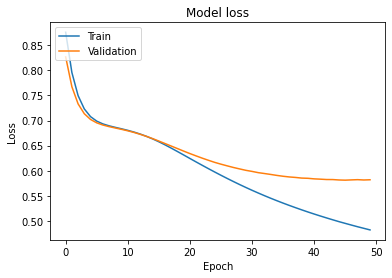

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

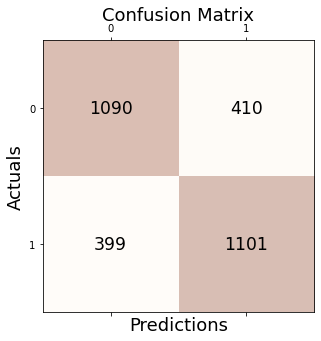

In [34]:
y_pred = model.predict(tfidf_test)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1500
           1       0.73      0.73      0.73      1500

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000

